In [1]:
"""
THE BEST IMPLEMENTATION IS WHEN YOU MAKE A CLASS AND STORE ALL INTERMEDIATE VARS IN SELF.VAR. THAT MAKES
DEBUGGING HECK OF A LOT EASIER BECAUSE IF ANYTHING FAILS, YOU CAN ALWAYS INSPECT ANY VAR BY CALLING 
PRINT(CLASS_INSTANCE.VAR). YOU CAN RUN CLASS METHODS SEPARATELY AND SEE THEIR OUTPUTS!
"""

# make sure you don't hog all the video memory
import os
import sys
import pickle
import time
import tensorflow as tf
from tensorflow.python.client import device_lib
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# os.environ["CUDAa_VISIBLE_DEVICES"]="2"
###################################

from keras import backend as K
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers import Input, Dense, Dropout, Flatten, ELU, Activation, Conv2D, Lambda, SeparableConv2D
from keras.models import Model, load_model

import gym
import numpy as np
from collections import deque

# import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
from skimage.color import rgb2gray


class DQNAgent:
    def __init__(self, frames):
        self.f_len = frames
        self.memory = deque(maxlen=self.f_len)
        self.target_shape = (80,80)
        self.fit_flag = True
#         self.state4 = np.zeros([80,80,self.f_len], dtype='float32')
        self.sum_disc_raw = []
        self.sum_raw_rew = []
        self.prev_raw_rew = -21
        self.init_env()
        self.init_brain()

        
        # Define the fit function (to update the weights; we won't be compiling the model)
        action_prob_placeholder = self.brain.output
        action_onehot_placeholder = K.placeholder(shape=(None, 2))
        discount_reward_placeholder = K.placeholder(shape=(None,))
        action_prob = K.sum(action_prob_placeholder * action_onehot_placeholder, axis=1)
        log_action_prob = K.log(action_prob)
        loss = - log_action_prob * discount_reward_placeholder
        loss = K.sum(loss)
        adam = Adam(lr=0.001)
        updates = adam.get_updates(params=self.brain.trainable_weights, loss=loss)
        self.fit = K.function(inputs=[self.brain.input,
                                           action_onehot_placeholder,
                                           discount_reward_placeholder],
                                   outputs=[loss],
                                   updates=updates)
    def init_brain(self):
        # this is the policy network
        input_img = Input(shape=(80, 80, self.f_len))
        x = Conv2D(16, (6, 6), activation='relu', padding='valid', strides=(4,4), kernel_initializer='lecun_uniform')(input_img)
        x = Conv2D(32, (2, 2), activation='relu', padding='valid', strides=(2,2), kernel_initializer='lecun_uniform')(x)
        x = Flatten()(x)
        x = Dense(250, activation='relu', kernel_initializer='lecun_uniform')(x)
        x = Dropout(0.33)(x)
        x = Dense(2)(x)
        x = Lambda(lambda x: K.tf.nn.softmax(x))(x)
        self.brain = Model(input_img, x)
        self.brain.summary()

    def init_env(self):
        # initialize the environment
        self.env = gym.make("Pong-v0")
        self.state = self.env.reset()
        self.done = False  
        # get the first four frames to fill the memory
        for i in range(self.f_len):
            self.action = np.random.choice([2,3])
            state, reward, self.done, _ = self.env.step(self.action)
            state = self.fi(state)
            self.memory.append(state) # нет ли смещения ????
        self.state4 = np.stack(self.memory, axis=2)
        self.state4 = self.state4[None,:,:,:]
        
    def step1(self):
        state, self.reward, self.done, _ = self.env.step(self.action)
        # self.env.render()
        state = self.fi(state)
        self.memory.append(state)
        self.state4 = np.stack(self.memory, axis=2)
        self.state4 = self.state4[None,:,:,:] if self.f_len > 1 else self.state4[None,:,:,:]
#         self.state4 = state - self.state4 ############### SUBTRACTION NOW
    
    def fi(self, I):
        """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
        I = I[35:195] # crop
        I = I[::2,::2,0] # downsample by factor of 2
        I[I == 144] = 0 # erase background (background type 1)
        I[I == 109] = 0 # erase background (background type 2)
        I[I != 0] = 1 # everything else (paddles, ball) just set to 1
        return I

    def predict_next_step(self):
        act = self.brain.predict(self.state4).flatten().tolist()
        act[1] = 1 - act[0] # this hack is needed because of numpy rounding error (probs don't sum to 1)
        self.action = np.random.choice([2,3],1, p=act) #### !!! ### !!! ###@@ you are more likely to send 2 if your policy net (brain) says [0.9 0.1]

    def discount_rewards(self, r, gamma=0.99):
        discounted_r = np.zeros_like(r, dtype='float32')
        running_add = 0
        for t in reversed(range(0, r.size)):
            if r[t] != 0:
                running_add = 0
            running_add = running_add * gamma + r[t]
            discounted_r[t] = running_add
#         discounted_r = discounted_r - 0.01
        sum_disc_raw = np.sum(discounted_r)
        discounted_r -= np.mean(discounted_r)
        discounted_r /= np.std(discounted_r)
        return discounted_r, sum_disc_raw

    def play1game(self):
        log_state4, log_reward, log_action = [], [], []
        for subep in range(1):
            self.init_env()
            while not self.done:
                self.predict_next_step()
                self.step1()
                log_state4.append(self.state4)
                log_reward.append(self.reward)
                log_action.append([1,0] if self.action==2 else [0,1]) #### !!! ### !!! ###@@ you are more likely to send 2 if your policy net (brain) says [0.9 0.1]
            log_state4 = self.invert_last(log_state4)
            d_rewards, sum_disc_raw = self.discount_rewards(np.array(log_reward), gamma=0.99)
            loss = self.fit([np.vstack(log_state4),
                             np.vstack(log_action),
                             d_rewards])
        self.sum_raw_rew = log_reward
        self.sum_disc_raw = sum_disc_raw
        return d_rewards, log_state4, log_action, loss

    def invert_last(self, log_state4):
        for i in range(len(log_state4)):
            log_state4[i] = log_state4[i].astype('float16')
            log_state4[i][:,:,:,0] = log_state4[i][:,:,:,0]*0.2
            log_state4[i][:,:,:,1] = log_state4[i][:,:,:,1]*0.4
            log_state4[i][:,:,:,2] = log_state4[i][:,:,:,2]*0.6
            log_state4[i][:,:,:,3] = log_state4[i][:,:,:,3]*0.8
#             print(np.max(log_state4[i][:,:,:,0]), np.max(log_state4[i][:,:,:,1]), np.max(log_state4[i][:,:,:,2]), np.max(log_state4[i][:,:,:,3]), np.max(log_state4[i][:,:,:,4]))
        return log_state4
        
    def save_if_reward_increased(self):
        tot_raw_rew = np.sum(self.sum_raw_rew)
        if (tot_raw_rew > self.prev_raw_rew):
            self.prev_raw_rew = tot_raw_rew
            print('saving weights_' + str(tot_raw_rew))
            name = str('2_PG_4frames_weights_' + str(tot_raw_rew) + '.h5')
            self.brain.save_weights(name)
    
    def model_diverges(self, log_action):
        print(np.mean([log_action[-i][0] for i in range(1,6)]))
        m_last_rews = np.mean([log_action[-i][0] for i in range(1,6)])
        return True if (m_last_rews > 0.6 or m_last_rews < 0.4) else False
    
    def train(self, n_episodes):
        acc_avg_up = []
        for episode in range(n_episodes):
            sys.stdout.write("\r EPISODE: {}".format(episode))
            sys.stdout.flush()
            d_rewards, log_state4, log_action, loss = self.play1game()
            avg_up = np.mean([log_action[i][0] for i in range(len(log_action))])
            acc_avg_up.append(avg_up)
            last_five = np.mean([acc_avg_up[-i] for i in range(1, np.min([5,len(acc_avg_up)]))])
            self.fit_flag = False if (last_five < 0.4 or last_five > 0.6) else True                
                
            self.save_if_reward_increased()
            with open("2_PG_4frames.txt", "a") as myfile:
                myfile.write("episode " + str(episode) + "\t" +
                             "loss " + str(np.round(loss, 2)) + "\t" 
                             " raw_d_rw " + str(np.round(self.sum_disc_raw,2)) + "\t" +
                             " raw_rw " + str(np.round(np.sum(self.sum_raw_rew),2)) + "\t" +
                             " avg_up " + str(np.round(avg_up,2)) + "\t" +
                             " game_len " + str(len(d_rewards)) + "\t" +
                             "\n")
        return log_state4

            

In [ ]:
agent = DQNAgent(frames=5)
log_state4 = agent.train(15000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 16)        2896      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          2080      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               648250    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 502       
__________

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


saving weights_-16.0
 EPISODE: 19saving weights_-15.0
 EPISODE: 183

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in less


 EPISODE: 3050

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 EPISODE: 7149

In [6]:
print(np.max(log_state4[130][:,:,:,0]))
print(np.max(log_state4[130][:,:,:,1]))
print(np.max(log_state4[130][:,:,:,2]))
print(np.max(log_state4[130][:,:,:,3]))
print(np.max(log_state4[130][:,:,:,4]))

# f = plt.figure(figsize=(15,15))
# for i in range(5):
#     ax = plt.subplot(1,5,i+1)
#     ax.imshow(log_state4[130][-1,:,:,i])
#     ax.set_title(np.max(log_state4[130][-1,:,:,i]))

0.2
0.4
0.6
0.8
1.0


In [16]:
log_state4[130][0,:,:,0] = log_state4[130][0,:,:,0] * -1.0
print(log_state4[130][0,:,:,0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [17]:
print('max', np.min(log_state4[130][:,:,:,0]))
log_state4[130][:,:,:,0] = np.negative(log_state4[130][:,:,:,0])
for i in range(80):
    for j in range(80):
        print(log_state4[130][0,i,j,0]) if not log_state4[130][0,i,j,0] == 0 else 'notzero'

max 0


In [92]:
log_state4[130][:,:,:,0].dtype

dtype('uint8')

In [94]:
np.unique(log_state4[130][:,:,:,0])

array([  0, 255], dtype=uint8)

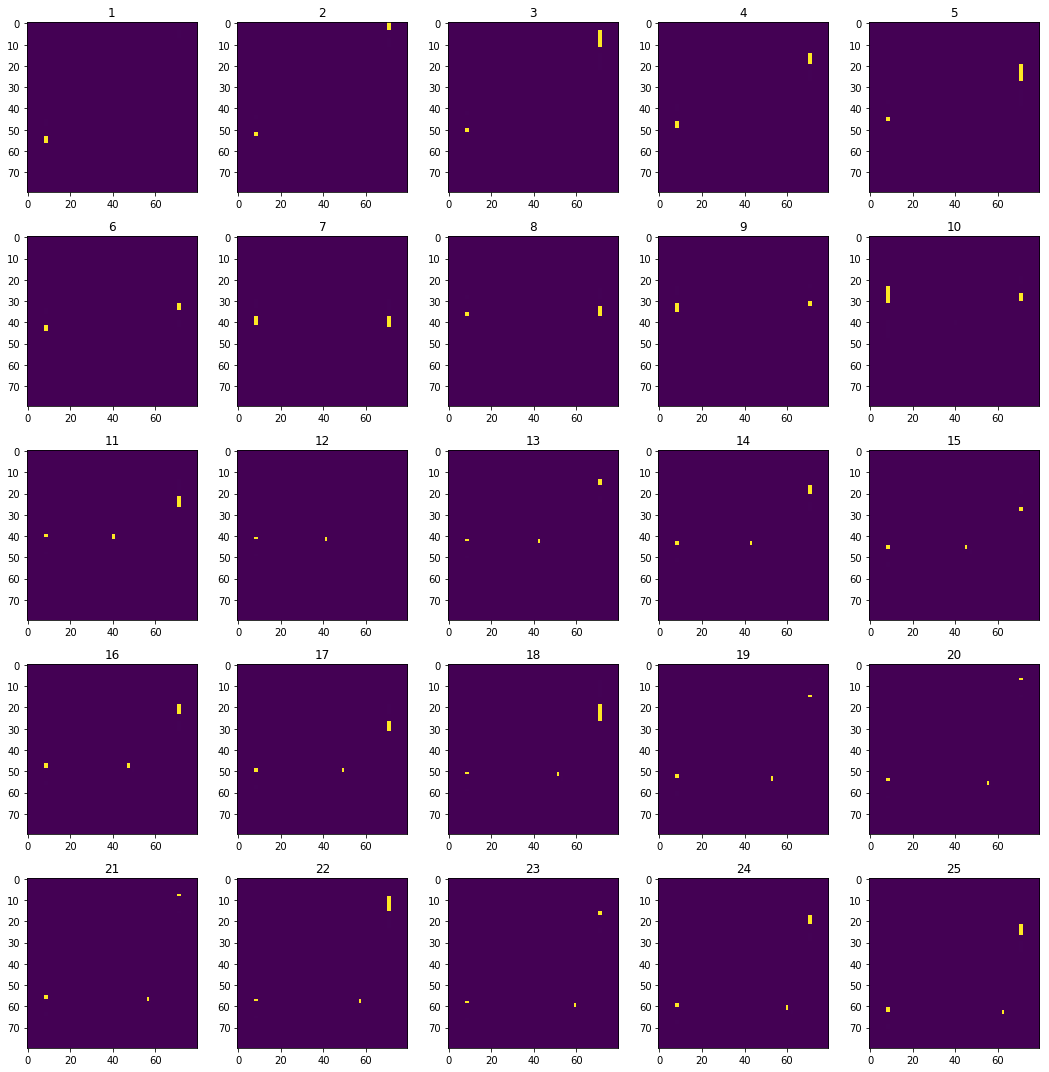

In [7]:
f = plt.figure(figsize=(15,15))
for i in range(1,26):
    a = log_state4[331+i][0,:,:,0] - log_state4[330+i][0,:,:,0]
    ax = plt.subplot(5,5,i)
    ax.imshow(a)
    ax.set_title(i)
    plt.tight_layout()

In [27]:
a = np.random.randint(255,size=(1,3,3,1)).astype('uint8')
print(a)
a = a*0.8
print(a)

[[[[239]
   [124]
   [ 68]]

  [[142]
   [ 49]
   [150]]

  [[ 13]
   [ 40]
   [ 36]]]]
[[[[191.2]
   [ 99.2]
   [ 54.4]]

  [[113.6]
   [ 39.2]
   [120. ]]

  [[ 10.4]
   [ 32. ]
   [ 28.8]]]]


In [41]:
for i in range(80):
    for j in range(80):
        a[0,i,j,0] = 0 if a[0,i,j,0]>30 else a[0,i,j,0]
np.max(a)

30